In [1]:
from tqdm import tqdm
import skillsnetwork
import numpy as np
import pandas as pd
#from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms 
%matplotlib inline
from math import ceil

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('dark')

In [2]:
df1 = pd.read_csv("ab_data.csv")
df1

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [15]:
df1['version'] = np.where(df1['landing_page'] == 'new_page', 'dark_mode', 'light_mode')

# filter the data based off of the version (dark or light mode)
old_conversion = df1[df1['version'] == 'light_mode']
new_conversion = df1[df1['version'] == 'dark_mode']

# get the conversion rates
light_converted = old_conversion['converted'].mean()
dark_converted = new_conversion['converted'].mean()

# print the results
print("The conversion rate in the group using light mode is: %.2f%%" % (100 * light_converted))
print("The conversion rate in the group using dark mode is: %.2f%%" % (100 * dark_converted))

The conversion rate in the group using light mode is: 11.10%
The conversion rate in the group using dark mode is: 12.50%


### 1. Formulate the null hyptohesis ($H_0$), alternative hypothesis ($H_1$), and alpha ($\alpha$) or level of significance

here, we use

$$
H_0: \text{Control Group} \\\\\\
H_1: \text{Treatment Group} \\
\alpha: \text{0.05 or 5\%}
$$

### 2. Prepare the data 

In [4]:
# check if some users appear multiple times
user_sessions = df1['user_id'].value_counts()

multiple_times_user = user_sessions[user_sessions > 1].count()

multiple_times_user

np.int64(3894)

In [7]:
dr = user_sessions[user_sessions > 1].index
df1 = df1[~df1['user_id'].isin(dr)]

df1

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


### 3. Give the baseline conversion rate, expect the conversion rate, power and alpha to find the sample size needed

here we use 

baseline conversion rate : 13%

expect conversion rate : 15%

power : 80% (recommended power level)

$\alpha$ : 0.05 

In [8]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

sample_size = sms.NormalIndPower().solve_power(
    effect_size,
    power = 0.8,
    alpha = 0.05,
    ratio = 1
)

sample_size = ceil(sample_size)

sample_size

4720

In [10]:
# The treatment and control samples
trt_sample = df1[df1['group']=='treatment'].sample(n=sample_size, random_state=888)

con_sample = df1[df1['group'] == 'control'].sample(n=sample_size, random_state=0)

# Combining into one dataframe and resetting the indices
df1 = pd.concat([con_sample, trt_sample], axis=0)
df1.reset_index(drop=True, inplace=True)

df1

,user_id,timestamp,group,landing_page,converted
0,740761,2017-01-19 23:06:22.166842,control,old_page,0
1,685906,2017-01-15 13:37:19.383548,control,old_page,0
2,803229,2017-01-02 14:46:36.522859,control,old_page,0
3,771051,2017-01-14 17:49:52.369447,control,old_page,0
4,726377,2017-01-18 11:18:54.592555,control,old_page,0
...,...,...,...,...,...
9435,663186,2017-01-12 19:21:57.769472,treatment,new_page,0
9436,697047,2017-01-13 02:32:25.839903,treatment,new_page,0
9437,682044,2017-01-05 05:28:52.436273,treatment,new_page,0
9438,728014,2017-01-21 12:55:55.633607,treatment,new_page,1


### 4. Visualize the results

In [16]:
df1.groupby(['group','version']).agg({'converted': 'mean'})

,,converted
group,version,
control,light_mode,0.111017
treatment,dark_mode,0.125000


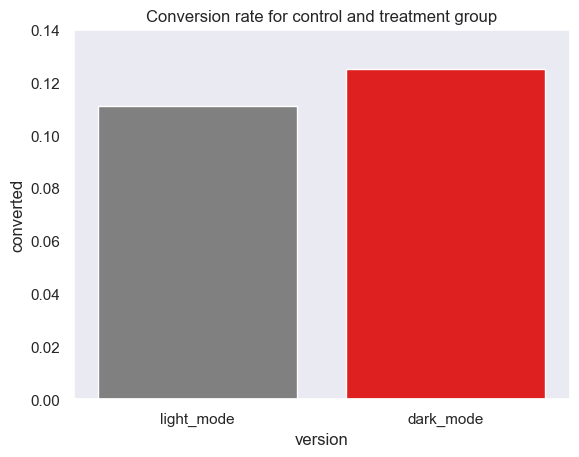

In [19]:
sns.barplot(x = df1['version'], y = df1['converted'], palette = ['gray', 'red'], ci = False)
plt.ylim(0, 0.14)
plt.title('Conversion rate for control and treatment group')
plt.show()

### 5. Testing the hypothesis

In [22]:
conv_cont = df1[df1['group'] =='control']['converted']

conv_trt = df1[df1['group'] =='treatment']['converted']

n_cont = conv_cont.count()

n_trt = conv_trt.count()

num_converted = [conv_cont.sum(), conv_trt.sum()]

nobs = [n_cont, n_trt]

# p-value?
z_stat, pval = sms.proportions_ztest(num_converted, nobs=nobs)

pval

np.float64(0.03524195278525257)

From the result, the p-value is 0.0352, which means we have **moderate evidence against the null hypothesis.**

In this case, we would reject the null hypothesis. This means that the team can choose to implement a dark mode version of the blog, but can continue monitoring the conversion results as time goes by.